In [1]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import scipy.stats
from scipy.interpolate import interp1d

from root_to_np import get_tree, get_df, rename_tree_branches

Welcome to JupyROOT 6.26/04
END OF SCRIPT


In [2]:
run = [630,636]
pad_name = [37,38,27,28]
which_mcp = [1,1,2,2]
centers_from_fit = np.loadtxt('/home/evridiki/Desktop/JULY_RUNS/run_627_632_info/pad_centers.txt',
                delimiter=" ", unpack=False)

#cross point
cross = [22.39996479308732, 25.69888050613195]
#cable delay
cable_delay = np.loadtxt(f'/home/evridiki/Desktop/JULY_RUNS/run_{run[0]}_{run[1]}_info/cable_delay.txt')
#cable_delay = cable_delay-np.array([7.,7.,6.,7.]) #630, 636 for central

# scale factors
p2 = np.loadtxt('/home/evridiki/Desktop/JULY_RUNS/run_627_632_info/scale_par.txt',
                delimiter=" ", usecols=(0))
p3 = np.loadtxt('/home/evridiki/Desktop/JULY_RUNS/run_627_632_info/scale_par.txt',
                delimiter=" ", usecols=(1))

color = np.array(['red','blue','purple','green'])

In [3]:
data = []
for irun in run:
    tree = get_tree(irun)
    
    var_indexes = np.array([1,2,4,5,6,7])
    for index in range(4):
        var_indexes = np.append(var_indexes,[index*10+8,index*10+9,index*10+13,index*10+11]) 
    var_indexes = np.append(var_indexes,[67,65,66])
    
    data_single = get_df(tree,*var_indexes)
    
    old_names = ['mcp_gpeak','mcp_qall','mcp_t']
    new_names = ['mcp1_gpeak','mcp1_qall','mcp1_t']
    names = [old_names,new_names]
    data_single = rename_tree_branches(data_single,*names)
    
    print(len(data_single))
    data.append(data_single)

data = pd.concat(data)
print(data.head())
print(len(data))

['Pico;1']
['srs', 'mcp_gpeak', 'mcp_qall', 'mcp_tnaive', 'mcp_t', 'mcp2_gpeak', 'mcp2_qall', 'mcp2_t', 'mm1_gpeak', 'mm1_qall', 'mm1_tnaive', 'mm1_t', 'mm1_qe', 'mm1_pl3', 'mm1_qfit', 'mm1_xh', 'mm1_qh', 'mm1_gmin', 'mm2_gpeak', 'mm2_qall', 'mm2_tnaive', 'mm2_t', 'mm2_qe', 'mm2_pl3', 'mm2_qfit', 'mm2_xh', 'mm2_qh', 'mm2_gmin', 'mm3_gpeak', 'mm3_qall', 'mm3_tnaive', 'mm3_t', 'mm3_qe', 'mm3_pl3', 'mm3_qfit', 'mm3_xh', 'mm3_qh', 'mm3_gmin', 'mm4_gpeak', 'mm4_qall', 'mm4_tnaive', 'mm4_t', 'mm4_qe', 'mm4_pl3', 'mm4_qfit', 'mm4_xh', 'mm4_qh', 'mm4_gmin', 'nmm1_x', 'mm1_x', 'nmm1_y', 'mm1_y', 'nmm2_x', 'mm2_x', 'nmm2_y', 'mm2_y', 'nmm3_x', 'mm3_x', 'nmm3_y', 'mm3_y', 'nmm4_x', 'mm4_x', 'nmm4_y', 'mm4_y', 'ntracks', 'xy', 'chi2', 'track_flag', 'ndetsintrack', 'distnextcluster']
<Report start=0 stop=5280 source='/home/evridiki/Downloads/test_run630.root:/Pico;1'>
<Report start=5280 stop=10560 source='/home/evridiki/Downloads/test_run630.root:/Pico;1'>
<Report start=10560 stop=15840 source='/ho

In [4]:
class Distribution:
    def __init__(self, dataset,cut):
        self.dataset = dataset
        self.cut = cut
        
    def GetDataset(self):
        return self.dataset
    
    def GetCut(self):
        return self.cut
 
    def GetHist(self,bins=100,range=[],density=True):
        if not range: #list is still empty
            range = [self.dataset[self.cut].min(),self.dataset[self.cut].max()]
        counts, edges = np.histogram(self.dataset[self.cut], range=range,
                             bins =bins, density = density)
        bin_centers = (edges[1:]+edges[:-1])/2
        return counts, edges, bin_centers
    
    def DisplayDensityHist(self,ax=plt ,color='black',bins=100,label=''):
        ax.hist(self.dataset[self.cut], bins =bins, 
                            color = color, histtype='step',label = label,density=True)
    
    def HistKDE(self):
        kde = scipy.stats.gaussian_kde(self.dataset[self.cut])
        return kde
    
    def PandasPlot(self,color='blue',bins=100,label='',range=[]):
        if not range: #list is still empty
            range = [self.dataset[self.cut].min(),self.dataset[self.cut].max()]
        data_ser = pd.Series(self.dataset[self.cut])
        data_ser.plot.hist(bins =bins, edgecolor='w', range=range,linewidth=0.2,
                            color = color,label = label,density=True)
    
    def FitFunction(self,f,p0, bins=100,range=[],density=True):
        c,_,b = self.GetHist(bins =bins,range=range, density = density)

        popt, pcov = curve_fit(f, b, c, p0=p0)
        
        return popt, np.sqrt(np.diag(pcov))
    

In [5]:
#define the cuts
mm_basic_cut= []

mcp_overflow = np.logical_and((data.mcp1_gpeak>0.3)*(data.mcp1_gpeak<=0.74),
                             (data.mcp2_gpeak>0.3)*(data.mcp2_gpeak<=0.74))
chi2_cut = (data.chi2<=50)*(data.track_flag>0)
mcp_basic_cut = mcp_overflow*chi2_cut

for index in range(4):
    pad = index+1
       
    mm_gpeak = f'mm{pad}_gpeak'
    mm_qall = f'mm{pad}_qall'
    mm_overflow = (data[mm_qall]<65)*(data[mm_gpeak]<0.36)*(data[mm_qall]>2.)
    cut = np.logical_and(mm_overflow,mcp_basic_cut)
    
    mm_basic_cut.append(cut)

In [6]:
xc = cross[0]
yc = cross[1]
radius = 2.
square_cut = np.logical_and(np.abs(data.iloc[:,-4]-xc)<radius, np.abs(data.iloc[:,-3]-yc)<radius)

In [7]:
def scale_function(x,p1,p2,p3):
    return p1*kde(p2*x+p3)


In [8]:
def double_gaus( x, *params ):
    (c1, mu, sigma1, c2, sigma2) = params
    res =   c1 * np.exp( - (x - mu)**2.0 / (2.0 * sigma1**2.0) ) \
          + c2 * np.exp( - (x - mu)**2.0 / (2.0 * sigma2**2.0) )
    return res
def simple_gaus(x,c,mu,sigma):
    res =   c * np.exp( - (x - mu)**2.0 / (2.0 * sigma**2.0) ) 
    return res
def double_sigma(x, *params):
    prob =  double_gaus(x,*params)/double_gaus(x,*params).sum()
    mu_double   = x.dot(prob)         # mean value
    mom2 = np.power(x, 2).dot(prob)  # 2nd moment
    var  = mom2 - mu_double**2        # variance
    sigma = np.sqrt(var) 
    return sigma

In [9]:
class SAT:
    def __init__(self, sat):
        self.sat = sat
    
    def GetAvrg(self,weights):
        avrg = np.average(self.sat,weights = weights)
        return avrg
    
    def GetWeightedStd(self,weights):
        variance = np.average((self.sat-self.GetAvrg(weights))**2, weights=weights)
        return np.sqrt(variance)
    
    def ReduceSAT(self,around=0, t_range=100):
        self.sat = self.sat[np.abs(self.sat- around)<= t_range] 
        
    def GetHist(self,bins=100):
        counts, edges = np.histogram(self.sat, bins =bins)
        bin_centers = (edges[1:]+edges[:-1])/2
        return counts, edges, bin_centers
        
    def PlotSAT(self,ax=plt, color='black',bins=100,label=''):
        c,_,b = self.GetHist(bins =bins)
        ax.errorbar(b, c, yerr=np.sqrt(c), fmt='o',markersize=4.,
                color=color,label= label)
        
    def PlotHist(self,ax=plt ,color='black',bins=100,label='',range=[]):
        if len(range)==0:
            range=[self.sat.min(),self.sat.max()]
        ax.hist(self.sat, bins =bins, range=range,
                            color = color, histtype='step',label = label)
        
    def FitSAT(self, f , p0,bins=100, param_bounds=([0.1,-np.inf,1,0.1,1],[np.inf,np.inf,np.inf,np.inf,np.inf])):
        if len(p0) != len(param_bounds[0]):
            print('ERROR!!! Check compatibility between parameters and their bounds')
            sys.exit(1)
            
        c,_,b = self.GetHist(bins =bins)
        popt, pcov = curve_fit(f, b, c, p0=p0, bounds = param_bounds)
        return popt

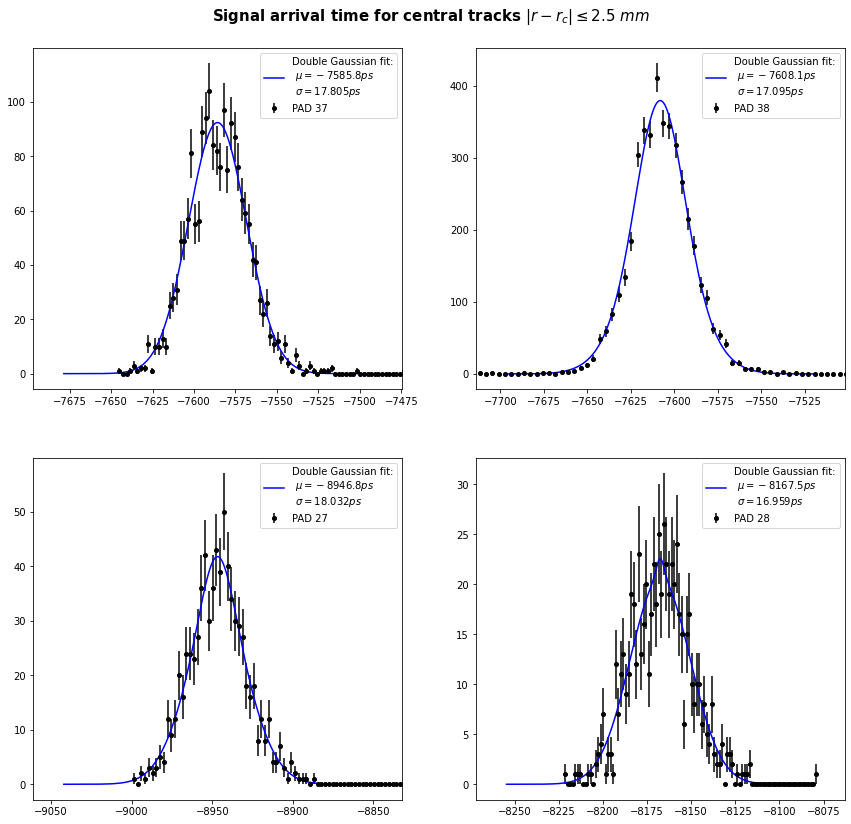

In [10]:
fig,axes = plt.subplots(figsize=(12,12))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.subplots_adjust(hspace=0.2)
fig.suptitle(r'Signal arrival time for central tracks $|r-r_c|\leq 2.5\ mm$', fontsize=15, fontweight='bold')

cable_delay = np.empty(4)

for index in range(4):
    pad=index+1
    mm_gpeak = f'mm{pad}_gpeak'
    mm_qall = f'mm{pad}_qall'
    mm_t = f'mm{pad}_t'
    mcp_t='mcp1_t'
    if(pad>2):
        mcp_t='mcp2_t'
    
    xc = centers_from_fit[0][index]
    yc = centers_from_fit[1][index]
    
    circle_cut = np.sqrt((data.iloc[:,-4]-xc)**2 + (data.iloc[:,-3]-yc)**2)<2.5
    mm_time_cut = mm_basic_cut[index]*(data[mm_gpeak]>0.03)*circle_cut

    sat = (data[mm_t][mm_time_cut] - data[mcp_t][mm_time_cut])*1000 #ps
    
    sat_hist = SAT(sat)
    w = np.abs(1/sat_hist.sat)
    avrg,std = sat_hist.GetAvrg(w), sat_hist.GetWeightedStd(w)
    
    sat_hist.ReduceSAT(avrg,10*std) # to exclude times waaay out of range
    #and update
    avrg,std = sat_hist.sat.mean(), sat_hist.sat.std()
    
    g2_par = np.array([350.,avrg,10,50,30])
    g2_par =sat_hist.FitSAT(f = double_gaus,p0=g2_par)
    (c1, mu, sigma1, c2, sigma2) = g2_par
    
    plt.subplot(2, 2, index + 1)
    sat_hist.PlotSAT(label=f'PAD {pad_name[index]}')
    x = np.linspace(mu-5*std,mu+5*std,2000)
    sigma_double = double_sigma(x,*g2_par)
    
    plt.plot(x,double_gaus(x,*g2_par),color='blue',
        label='Double Gaussian fit:\n $\mu = {:.1f} ps$ \n $\sigma = {:.3f} ps$'.format(g2_par[1],sigma_double))
    plt.legend(loc='upper right')
    plt.xlim(mu-6*std,mu+6*std)

    cable_delay[index] = g2_par[1]
    
plt.show()

In [11]:
def t_range_cut(t):
    t_low = -1200
    t_up = 1200
    return np.logical_and(t>=t_low,t<=t_up)

def double_expo(x,*p):
    return np.exp(p[0]*x+p[1])+np.exp(p[2]*x+p[3])+p[4]

In [12]:
def slew_resol(sat,x,num_points = 45,t_out_of_range=600):   
    d = {'sat':sat,'x':x}
    t_fun_x = pd.DataFrame(data=d)

    # sort
    t_fun_x.sort_values(by=['x'], inplace=True)
    #print('number of valid events ',len(t_fun_x))
    #binning
    len_xbin = round(len(t_fun_x)/num_points)
    print('number of events per point ',len_xbin)
    
    arr = np.empty((0,7))
    for j in range(num_points):
        start =j*len_xbin
        end = (j+1)*len_xbin
        if(end>len(t_fun_x)):
            end = len(t_fun_x)
        
        x = t_fun_x.iloc[start:end,1].values
        t = t_fun_x.iloc[start:end,0].values
        mean = np.average(t,weights = np.abs(1/(t-t.mean())))
        t = t[np.abs(t-mean)<=t_out_of_range] # to cut times waaay out of range
        if(len(t)==0):
            print('zero left')
            continue

        xbin_hist = ROOT.TH1F(""," ", 100,t.mean()-5*t.std(),t.mean()+5*t.std());
        xbin_hist.FillN(len(t),t,np.ones(len(t)))
        result = xbin_hist.Fit('gaus','QS')
        arr = np.append(arr,
                        np.array([[x.mean() , np.abs(x[0]-x.mean()), np.abs(x[-1]-x.mean()),
                                  result.Parameter(1), result.ParError(1), result.Parameter(2),result.ParError(2)]]),
                        axis = 0)
    
    return arr

In [13]:
class SlewResol:
    def __init__(self,x,y,x_err=[0,0],y_err=0):
        self.x = x
        self.y = y
        self.x_err = x_err
        self.y_err = y_err
        
    def AbortPoint(self,position):
        self.x = np.delete(self.x,position)
        self.y = np.delete(self.y,position)
        self.x_err = [np.delete(self.x_err[0],position), np.delete(self.x_err[1],position)]
        self.y_err = np.delete(self.y_err,position)
        
    def PlotGraph(self,ax=plt,label='',color='cyan'):
        ax.errorbar(self.x,self.y, yerr =self.y_err ,xerr=self.x_err,fmt='o',
             label =label,color = color, markersize=5. )
        
    def PlotFunction(self,f,par=[],limits=[],ax=plt,label='fit function',color='black'):
        if len(limits)==0:
            limits = [self.x.min(),self.x.max()]
            
        xs = np.linspace(limits[0],limits[1],1000)
        ys = f(xs,*par)
        ax.plot(xs,ys,linewidth='2',label =label,color = color )
        

    def ScaleX(self,p2,p3):
        self.x = p2*self.x +p3
        
    def FitFunction(self,f,p0):
        popt, pcov = curve_fit(f, self.x,self.y,sigma=self.y_err, p0= p0, absolute_sigma=True)
        return popt, pcov
    
    def CorrectForFunction(self,f,par):
        self.y = self.y - f(self.x,*par)
        
    def CorrectCable(self,const):
        self.y = self.y - const
        
    def GetArray(self):
        return np.array([self.x,self.x_err[0],self.x_err[1],self.y,self.y_err])
    
    def Interpolation(self,kind='cubic'):
        limits=[self.x[0],self.x[-1]]
        return interp1d(self.x,self.y, kind=kind), limits

# ##########

In [14]:
for index in range(4):
    pad=index+1
    mm_gpeak = f'mm{pad}_gpeak'
    mm_qall = f'mm{pad}_qall'
    mm_t = f'mm{pad}_t'
    mcp_t=f'mcp{which_mcp[index]}_t'
    data[mm_qall] = p2[index]*data[mm_qall]+p3[index]
    data[mm_t] = (data[mm_t]-data[mcp_t])*1000 - cable_delay[index]

In [15]:
dp = {}

In [16]:
slew = [[None] * 4 for i in range(4)]
for k in range(4):
    pad=k+1
    mm_gpeak = f'mm{pad}_gpeak'
    mm_qall = f'mm{pad}_qall'
    mm_t = f'mm{pad}_t'

    mm_time_cut = mm_basic_cut[k]*(data[mm_gpeak]>0.008)*square_cut
    mm_time_cut =mm_time_cut*t_range_cut(data[mm_t])
    
    sat = data[mm_time_cut][mm_t]
    q =data[mm_time_cut][mm_qall]
    print(f'k={k}->',len(sat))
    A = data[mm_time_cut][['mm1_qall','mm2_qall','mm3_qall','mm4_qall']].idxmax(axis=1)
    
    for j in range(4):
        satj = sat[A.values==f'mm{j+1}_qall']
        qj = q[A.values==f'mm{j+1}_qall']
        print(f'k={k}, j={j}->',len(satj))
    
        slew[k][j] = slew_resol(satj,qj,num_points =10)
    
        
        graph = SlewResol(x=slew[k][j][:,0],y=slew[k][j][:,3],
                      x_err=[slew[k][j][:,1],slew[k][j][:,2]],y_err=slew[k][j][:,4])
        par = np.array([-1.,5.,-0.2,5.,10.])
        try:
            par,_ = graph.FitFunction(f=double_expo, p0=par)
            print(f'k={k}, j={j}->par = ',par)
        except:
            print('not at first..')
            par = np.array([-1.5,5.,-0.2,8.,70.])
            par,_ = graph.FitFunction(f=double_expo, p0=par)
            print(f'k={k}, j={j}->par = ',par)
        print('########################')
        
        dp[(k,j)]=par
    
    


k=0-> 24773
k=0, j=0-> 6629
number of events per point  663


/tmp/ipykernel_20051/4130863676.py:7: RuntimeWarning: overflow encountered in exp
  return np.exp(p[0]*x+p[1])+np.exp(p[2]*x+p[3])+p[4]
/home/evridiki/Desktop/JULY_RUNS/py_analysis/pyanalysis/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_20051/4130863676.py:7: RuntimeWarning: overflow encountered in exp
  return np.exp(p[0]*x+p[1])+np.exp(p[2]*x+p[3])+p[4]
/home/evridiki/Desktop/JULY_RUNS/py_analysis/pyanalysis/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_20051/4130863676.py:7: RuntimeWarning: overflow encountered in exp
  return np.exp(p[0]*x+p[1])+np.exp(p[2]*x+p[3])+p[4]
/home/evridiki/Desktop/JULY_RUNS/py_analysis/pyanalysis/lib/python3.8/site

k=0, j=0->par =  [-2.36179976 -7.57070353 -0.12667854  4.95424295 13.7298074 ]
########################
k=0, j=1-> 6403
number of events per point  640
k=0, j=1->par =  [-0.686771    6.70437558 -0.29158048  6.23610475 58.77249483]
########################
k=0, j=2-> 7018
number of events per point  702
k=0, j=2->par =  [-0.87063092  7.11704895 -0.25801313  5.91031146 51.67736474]
########################
k=0, j=3-> 4723
number of events per point  472
k=0, j=3->par =  [-0.50931873  7.23883719 -0.50934362  3.72987936 90.73597051]
########################
k=1-> 26127
k=1, j=0-> 6048
number of events per point  605
k=1, j=0->par =  [-1.70358739  8.21835248 -0.30479588  6.35173191 56.93881008]
########################
k=1, j=1-> 7369
number of events per point  737
k=1, j=1->par =  [-2.27049548 -3.6024369  -0.12256445  4.86592693 15.4678762 ]
########################
k=1, j=2-> 4737
number of events per point  474
not at first..
k=1, j=2->par =  [-10.63657481 -12.21765427  -0.50560695   7.

/home/evridiki/Desktop/JULY_RUNS/py_analysis/pyanalysis/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_20051/4130863676.py:7: RuntimeWarning: overflow encountered in exp
  return np.exp(p[0]*x+p[1])+np.exp(p[2]*x+p[3])+p[4]
Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


In [53]:
dp[(0,0)]= np.array([-2.36179976, -3.57070353, -0.12667854,  4.95424295, 13.7298074])
dp[(3,3)]= np.array([-1.99989521, -3.69210729, -0.14391473,  5.06379388, 14.2313532])

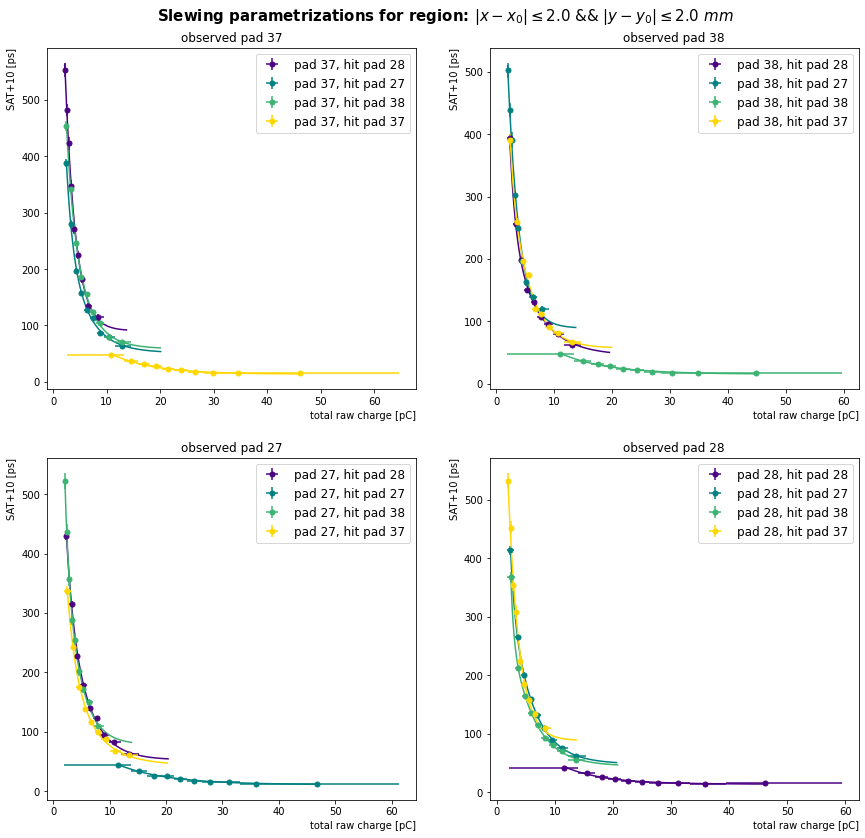

In [54]:
fig,axes = plt.subplots(figsize=(12,12))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.subplots_adjust(hspace=0.2)
fig.suptitle(f'Slewing parametrizations for region: $|x-x_0|\leq {radius}\ &&\ |y-y_0|\leq {radius}\ mm$', 
             fontsize=15, fontweight='bold')
colorj = ['gold', 'mediumseagreen','teal','indigo']

for k in range(4):
    for j in [3,2,1,0]:
        plt.subplot(2, 2, k+1)
        if k!=j:
            plt.errorbar(slew[k][j][:-1,0],slew[k][j][:-1,3], yerr =slew[k][j][:-1,4] ,
                         xerr=[slew[k][j][:-1,1],slew[k][j][:-1,2]],
                    fmt='o', markersize=5.,label=f'pad {pad_name[k]}, hit pad {pad_name[j]}',color=colorj[j] )
        else:
            plt.errorbar(slew[k][j][:,0],slew[k][j][:,3], yerr =slew[k][j][:,4] ,xerr=[slew[k][j][:,1],slew[k][j][:,2]],
                    fmt='o', markersize=5.,label=f'pad {pad_name[k]}, hit pad {pad_name[j]}',color=colorj[j] )
        
        x = np.linspace(slew[k][j][0,0],slew[k][j][-1,0],150)
        y = double_expo(x,*dp[(k,j)])
        plt.plot(x,y,color=colorj[j])
        plt.ylabel('SAT+10 [ps]',loc='top')
        plt.xlabel('total raw charge [pC]',loc='right')
        plt.legend(prop={'size': 12})
        plt.grid()
        plt.title(f'observed pad {pad_name[k]}')
plt.show()

In [55]:
dpr={}
for k in range(4):
    for j in range(4):
        #fit to find resol
        graph = SlewResol(x=slew[k][j][:,0],y=slew[k][j][:,5],
                      x_err=[slew[k][j][:,1],slew[k][j][:,2]],y_err=slew[k][j][:,6])
        par = np.array([-0.3,  5., -0.1,   5., 15.])
        try:
            par,_ = graph.FitFunction(f=double_expo, p0=par)
            print(f'k={k}, j={j}->par = ',par)
        except:
            print('not at first..')
            par = np.array([-1.,  5., -0.1,   5., 15.])
            par,_ = graph.FitFunction(f=double_expo, p0=par)
            print(f'k={k}, j={j}->par = ',par)
            
        print('########################')
        
        dpr[(k,j)]=par

k=0, j=0->par =  [ -2.84541008 -11.92962252  -0.11790898   4.48787586  18.24324002]
########################
k=0, j=1->par =  [-0.40094689  5.92067345 -0.03732539  4.08933161  6.47168846]
########################
k=0, j=2->par =  [-0.58876034  5.25689142 -0.22625534  5.28443678 33.23906093]
########################
k=0, j=3->par =  [-0.3767999   5.97382659 -0.37683643  3.59520996 52.36086005]
########################
k=1, j=0->par =  [-0.47339363  5.5720153  -0.19340605  4.79373594 30.24034457]
########################
not at first..
k=1, j=1->par =  [-2.44156120e+01  1.79706346e+02 -8.58900056e-02  3.92680525e+00
  1.58653198e+01]
########################
k=1, j=2->par =  [-0.35556775  5.86864146 -0.3555777   3.66076902 47.22088176]
########################
k=1, j=3->par =  [-0.49888991  5.7939269  -0.12322823  4.33614198 25.44115595]
########################
k=2, j=0->par =  [-1.08794738  6.28176025 -0.23636993  5.22356186 30.40180585]
########################
k=2, j=1->par =  [-0.38

/home/evridiki/Desktop/JULY_RUNS/py_analysis/pyanalysis/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_20051/4130863676.py:7: RuntimeWarning: overflow encountered in exp
  return np.exp(p[0]*x+p[1])+np.exp(p[2]*x+p[3])+p[4]


In [56]:
dpr[(3,3)]=np.array([-1.5, 6., -0.09199558,  3.86942369, 16.71027279])

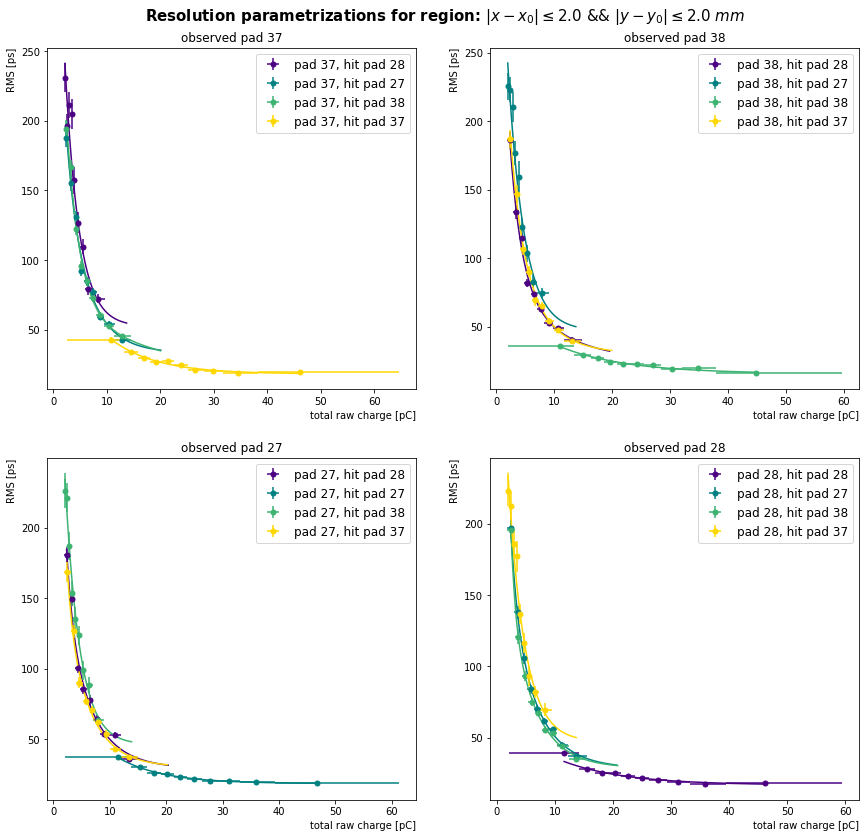

In [57]:
fig,axes = plt.subplots(figsize=(12,12))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.subplots_adjust(hspace=0.2)
fig.suptitle(f'Resolution parametrizations for region: $|x-x_0|\leq {radius}\ &&\ |y-y_0|\leq {radius}\ mm$', 
             fontsize=15, fontweight='bold')

for k in range(4):
    for j in [3,2,1,0]:
        plt.subplot(2, 2, k+1)
        if k!=j:
            plt.errorbar(slew[k][j][:-1,0],slew[k][j][:-1,5], yerr =slew[k][j][:-1,6] ,
                         xerr=[slew[k][j][:-1,1],slew[k][j][:-1,2]],
                    fmt='o', markersize=5.,label=f'pad {pad_name[k]}, hit pad {pad_name[j]}',color=colorj[j] )
        else:
            plt.errorbar(slew[k][j][:,0],slew[k][j][:,5], yerr =slew[k][j][:,6] ,
                         xerr=[slew[k][j][:,1],slew[k][j][:,2]],
                    fmt='o', markersize=5.,label=f'pad {pad_name[k]}, hit pad {pad_name[j]}',color=colorj[j] )
         
        x = np.linspace(slew[k][j][0,0],slew[k][j][-1,0],150)
        y = double_expo(x,*dpr[(k,j)])
        plt.plot(x,y,color=colorj[j])
        plt.ylabel('RMS [ps]',loc='top')
        plt.xlabel('total raw charge [pC]',loc='right')
        plt.legend(prop={'size': 12})
        plt.grid()
        plt.title(f'observed pad {pad_name[k]}')
plt.show()

In [58]:
xc = cross[0]#+9.82/4
yc = cross[1]#-9.82/3
radius = 2.

square_cut = np.logical_and(np.abs(data.iloc[:,-4]-xc)<radius, np.abs(data.iloc[:,-3]-yc)<radius)

In [59]:
subdata=[None]*4

for index in [0,1,2,3]:
    pad=index+1
    mm_gpeak = f'mm{pad}_gpeak'
    mm_qall = f'mm{pad}_qall'
    mm_t = f'mm{pad}_t'
    mcp_t=f'mcp{which_mcp[index]}_t'
    mm_overflow = (data[mm_qall]>0.5)*(data[mm_gpeak]<0.36)

    mm_basic_cut[index] = np.logical_and(mm_overflow,mcp_basic_cut)
    mm_time_cut = mm_basic_cut[index]*square_cut
    
    subdata[index]=data[mm_time_cut]

comondata = subdata[0].merge(subdata[1], how = 'inner' ,indicator=False)
comondata = comondata.merge(subdata[2], how = 'inner' ,indicator=False)
comondata = comondata.merge(subdata[3], how = 'inner' ,indicator=False)

print(len(comondata)) #all pads not overflowing

23167


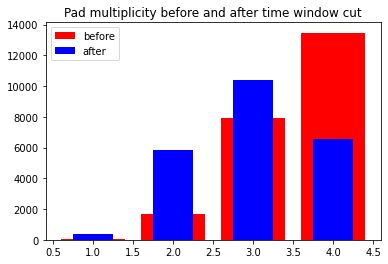

In [78]:
#pads activity
act_sum_prev = np.zeros(len(comondata),dtype=int)
active_sum = np.zeros(len(comondata),dtype=int)
q_active = 2. # to be considered active
for index in range(4):
    active_condition = ((comondata[f'mm{index+1}_qall'])>q_active)
    act_sum_prev = act_sum_prev + active_condition*1
    
    active_condition = ((comondata[f'mm{index+1}_qall'])>q_active)*(np.abs(comondata[f'mm{index+1}_t'])<300)
    active_sum = active_sum + active_condition*1

plt.bar([1,2,3,4],[len(act_sum_prev[act_sum_prev==1]),len(act_sum_prev[act_sum_prev==2]),
                   len(act_sum_prev[act_sum_prev==3]),len(act_sum_prev[act_sum_prev==4])],
        color='red',label='before')
plt.bar([1,2,3,4],[len(active_sum[active_sum==1]),len(active_sum[active_sum==2]),
                   len(active_sum[active_sum==3]),len(active_sum[active_sum==4])],
        color='blue',width=0.5,label='after')
plt.title('Pad multiplicity before and after time window cut')
plt.legend()
plt.show()

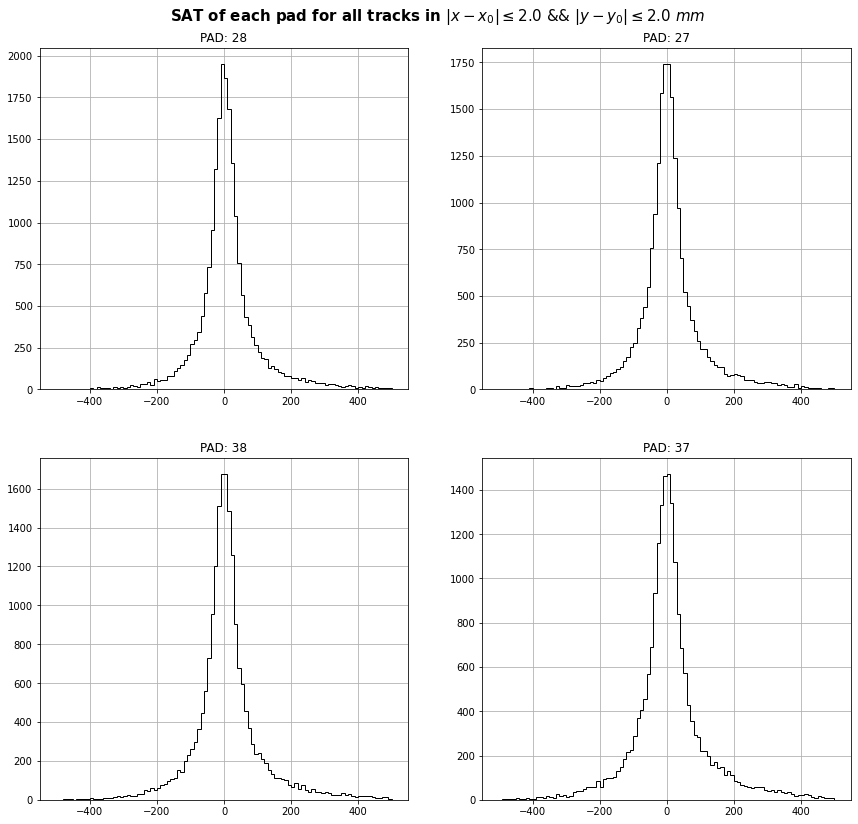

In [61]:
fig,axes = plt.subplots(figsize=(12,12))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.subplots_adjust(hspace=0.2)
fig.suptitle(f'SAT of each pad for all tracks in $|x-x_0|\leq {radius}\ &&\ |y-y_0|\leq {radius}\ mm$', 
             fontsize=15, fontweight='bold')
Tindiv_pads = [None]*4

for index in range(4):
        pad=index+1
        mm_qall = f'mm{pad}_qall'
        mm_t = f'mm{pad}_t'
        mcp_t=f'mcp{which_mcp[index]}_t'
        q_cut = comondata[mm_qall]>2.
    
        
        q_scale = comondata[q_cut][mm_qall]
        ########
        # to find max charge: A ---> hit pad---> p0..p4 adgust
        A = comondata[q_cut][['mm1_qall','mm2_qall','mm3_qall','mm4_qall']].idxmax(axis=1)
        dp0 = [dp[( index,int(j[2])-1 )][0] for j in A]
        dp1 = [dp[( index,int(j[2])-1 )][1] for j in A]
        dp2 = [dp[( index,int(j[2])-1 )][2] for j in A]
        dp3 = [dp[( index,int(j[2])-1 )][3] for j in A]
        dp4 = [dp[( index,int(j[2])-1 )][4] for j in A]
        
        ij = pd.concat([q_scale,A],axis=1)
        ij['dp0'] = dp0
        ij['dp1'] = dp1
        ij['dp2'] = dp2
        ij['dp3'] = dp3
        ij['dp4'] = dp4

        ij['cor'] = np.exp(ij[mm_qall]*ij['dp0']+ij['dp1'])+np.exp(ij[mm_qall]*ij['dp2']+ij['dp3'])+ij['dp4']
        cor = ij['cor']
        ########
        #same for resol
        dp0 = [dpr[( index,int(j[2])-1 )][0] for j in A]
        dp1 = [dpr[( index,int(j[2])-1 )][1] for j in A]
        dp2 = [dpr[( index,int(j[2])-1 )][2] for j in A]
        dp3 = [dpr[( index,int(j[2])-1 )][3] for j in A]
        dp4 = [dpr[( index,int(j[2])-1 )][4] for j in A]
        
        ij['dp0'] = dp0
        ij['dp1'] = dp1
        ij['dp2'] = dp2
        ij['dp3'] = dp3
        ij['dp4'] = dp4

        ij['cor'] = np.exp(ij[mm_qall]*ij['dp0']+ij['dp1'])+np.exp(ij[mm_qall]*ij['dp2']+ij['dp3'])+ij['dp4']
        resol = ij['cor']
        ########
        sat = (comondata[q_cut][mm_t])-cor+1.5 #ps
        
         
        Tindiv_pads[index]=SAT(sat)
    
        w = np.abs(1/(Tindiv_pads[index].sat))
        avrg,std = Tindiv_pads[index].GetAvrg(w), Tindiv_pads[index].GetWeightedStd(w)
        Tindiv_pads[index].ReduceSAT(avrg,500) # to exclude times waaay out of range
            
        plt.subplot(2, 2, 4-index)
        if len(Tindiv_pads[index].sat)<5:
            continue
    
        w = 1/np.abs(Tindiv_pads[index].sat)
        avrg, std = Tindiv_pads[index].GetAvrg(w), Tindiv_pads[index].GetWeightedStd(w)
    
        Tindiv_pads[index].PlotHist(range=[-500,500])
        plt.grid()
        
        plt.title(f'PAD: {pad_name[index]}')

plt.show()

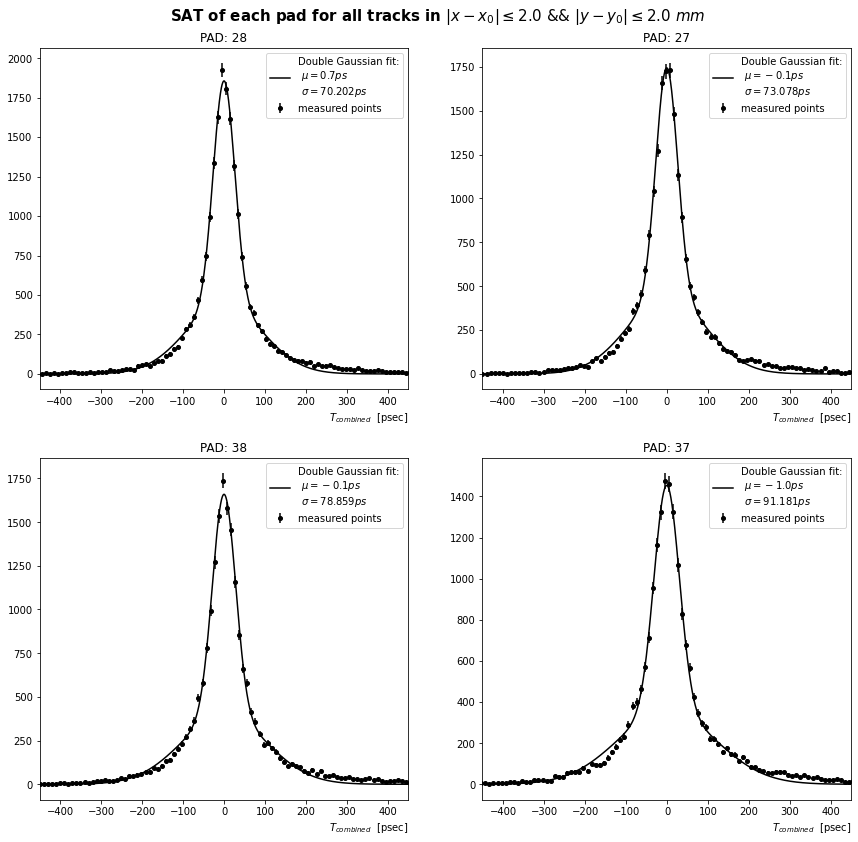

In [62]:
fig,axes = plt.subplots(figsize=(12,12))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.subplots_adjust(hspace=0.2)
fig.suptitle(f'SAT of each pad for all tracks in $|x-x_0|\leq {radius}\ &&\ |y-y_0|\leq {radius}\ mm$', 
             fontsize=15, fontweight='bold')

for index in [0,1,2,3]:
    
    plt.subplot(2, 2, 4-index)
    if len(Tindiv_pads[index].sat)<5:
        continue
    
    w = np.abs(1/Tindiv_pads[index].sat)
    avrg,std = Tindiv_pads[index].GetAvrg(w), Tindiv_pads[index].GetWeightedStd(w)
    std=450/5
    #Tindiv_pads[index].ReduceSAT(avrg,450) # to exclude times waaay out of range
    #and update
    #avrg,std = Tindiv_pads[index].sat.mean(), Tindiv_pads[index].sat.std()
    
    c,_,_ = Tindiv_pads[index].GetHist()
    g2_par = np.array([c.max(),0.,10,c.max()/3,30])
    g2_par =Tindiv_pads[index].FitSAT(f = double_gaus,p0=g2_par)
    g2_par =Tindiv_pads[index].FitSAT(f = double_gaus,p0=g2_par)
    (c1, mu, sigma1, c2, sigma2) = g2_par
    
    Tindiv_pads[index].PlotSAT(label='measured points')
    x = np.linspace(mu-5*std,mu+5*std,2000)
    sigma_double = double_sigma(x,*g2_par)
    
    plt.plot(x,double_gaus(x,*g2_par),color='k',
         label='Double Gaussian fit:\n $\mu = {:.1f} ps$ \n $\sigma = {:.3f} ps$'.format(mu,sigma_double))
    plt.legend(loc='upper right')
    plt.title(f'PAD: {pad_name[index]}')
    plt.xlabel(r'$T_{combined}$  [psec]',loc='right')
    plt.xlim(mu-5*std,mu+5*std)

plt.show()

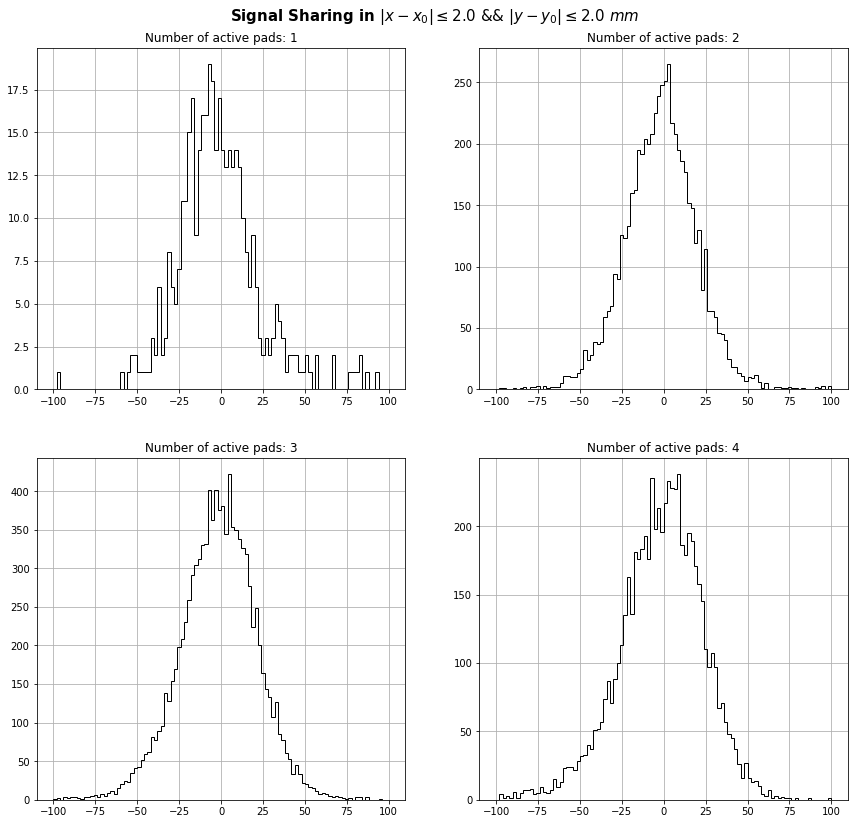

In [63]:
fig,axes = plt.subplots(figsize=(12,12))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.subplots_adjust(hspace=0.2)
fig.suptitle(f'Signal Sharing in $|x-x_0|\leq {radius}\ &&\ |y-y_0|\leq {radius}\ mm$', 
             fontsize=15, fontweight='bold')
Tcombined = [None]*4
Tpull = [None]*4

for active_pads in [1,2,3,4]:

    sum_nom=np.zeros(len(active_sum[active_sum==active_pads]))
    sum_denom=np.zeros(len(active_sum[active_sum==active_pads]))
    sum_pull = np.zeros(len(active_sum[active_sum==active_pads]))

    for index in range(4):
        pad=index+1
        mm_qall = f'mm{pad}_qall'
        mm_t = f'mm{pad}_t'
        mcp_t=f'mcp{which_mcp[index]}_t'
    
        q_scale = comondata[active_sum==active_pads][mm_qall]
        ########
        # to find max charge: A ---> hit pad---> p0..p4 adgust
        A = comondata[active_sum==active_pads][['mm1_qall','mm2_qall','mm3_qall','mm4_qall']].idxmax(axis=1)
        dp0 = [dp[( index,int(j[2])-1 )][0] for j in A]
        dp1 = [dp[( index,int(j[2])-1 )][1] for j in A]
        dp2 = [dp[( index,int(j[2])-1 )][2] for j in A]
        dp3 = [dp[( index,int(j[2])-1 )][3] for j in A]
        dp4 = [dp[( index,int(j[2])-1 )][4] for j in A]
        
        ij = pd.concat([q_scale,A],axis=1)
        ij['dp0'] = dp0
        ij['dp1'] = dp1
        ij['dp2'] = dp2
        ij['dp3'] = dp3
        ij['dp4'] = dp4

        ij['cor'] = np.exp(ij[mm_qall]*ij['dp0']+ij['dp1'])+np.exp(ij[mm_qall]*ij['dp2']+ij['dp3'])+ij['dp4']
        cor = ij['cor']
        ########
        sat = (comondata[active_sum==active_pads][mm_t])-cor-1.5 #ps
        
        ########
        #same for resol
        dp0 = [dpr[( index,int(j[2])-1 )][0] for j in A]
        dp1 = [dpr[( index,int(j[2])-1 )][1] for j in A]
        dp2 = [dpr[( index,int(j[2])-1 )][2] for j in A]
        dp3 = [dpr[( index,int(j[2])-1 )][3] for j in A]
        dp4 = [dpr[( index,int(j[2])-1 )][4] for j in A]
        
        ij['dp0'] = dp0
        ij['dp1'] = dp1
        ij['dp2'] = dp2
        ij['dp3'] = dp3
        ij['dp4'] = dp4

        ij['cor'] = np.exp(ij[mm_qall]*ij['dp0']+ij['dp1'])+np.exp(ij[mm_qall]*ij['dp2']+ij['dp3'])+ij['dp4']
        resol = ij['cor']
    
        active_condition =(q_scale>q_active)*(np.abs(sat)<300)
    
        sum_nom = sum_nom + active_condition*sat/resol**2
        sum_denom = sum_denom +active_condition*1/resol**2
        sum_pull = sum_pull + active_condition*sat/resol
    
    t_comb = sum_nom/sum_denom  
    Tcombined[active_pads-1]=SAT(t_comb)
    Tpull[active_pads-1] = SAT(sum_pull)
    
    w = np.abs(1/(Tcombined[active_pads-1].sat))
    avrg,std = Tcombined[active_pads-1].GetAvrg(w), Tcombined[active_pads-1].GetWeightedStd(w)
    #Tcombined[active_pads-1].ReduceSAT(avrg,15*std) # to exclude times waaay out of range
    #and update
    avrg,std = Tcombined[active_pads-1].sat.mean(), Tcombined[active_pads-1].sat.std()
    
    plt.subplot(2, 2, active_pads)
    if len(Tcombined[active_pads-1].sat)<5:
        continue
    
    w = 1/np.abs(Tcombined[active_pads-1].sat)
    avrg, std = Tcombined[active_pads-1].GetAvrg(w), Tcombined[active_pads-1].GetWeightedStd(w)
    
    Tcombined[active_pads-1].PlotHist(range=[-100,100])
    plt.grid()
    plt.title(f'Number of active pads: {active_pads}')

plt.show()

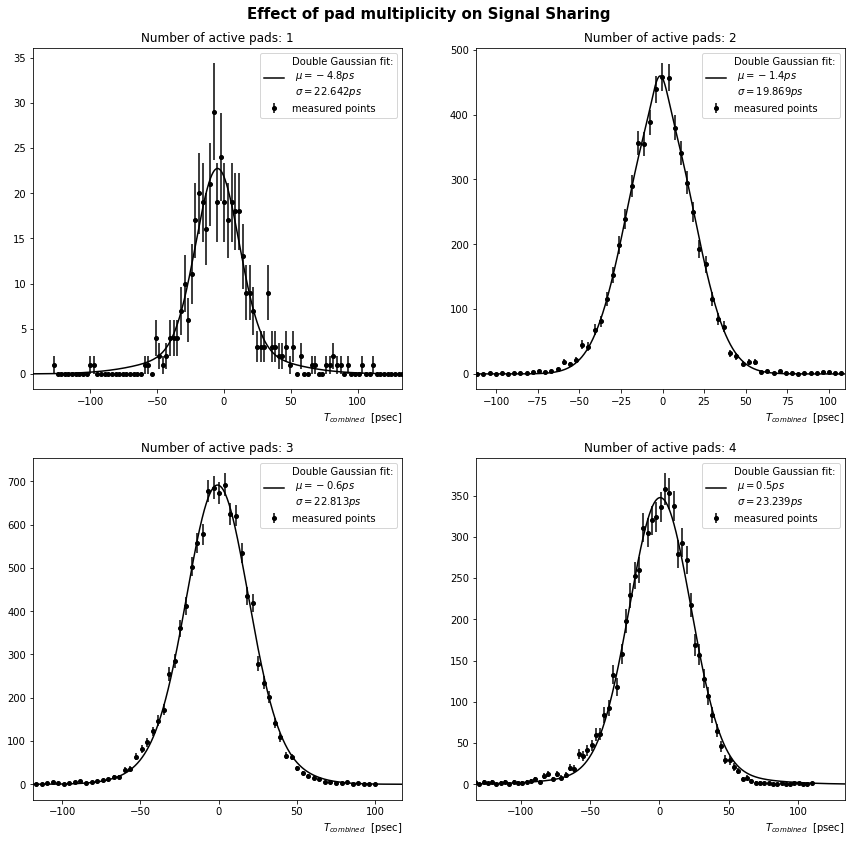

In [79]:
fig,axes = plt.subplots(figsize=(12,12))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.subplots_adjust(hspace=0.2)
fig.suptitle('Effect of pad multiplicity on Signal Sharing ', 
             fontsize=15, fontweight='bold')

for active_pads in [1,2,3,4]:
    index = active_pads-1
    
    plt.subplot(2, 2, active_pads)
    if len(Tcombined[index].sat)<5:
        continue
    
    w = np.abs(1/Tcombined[index].sat)
    avrg,std = Tcombined[index].GetAvrg(w), Tcombined[index].GetWeightedStd(w)
    
    #Tcombined[index].ReduceSAT(avrg,15*std) # to exclude times waaay out of range
    #and update
    avrg,std = Tcombined[index].sat.mean(), Tcombined[index].sat.std()
    
    c,_,_ = Tcombined[index].GetHist()
    g2_par = np.array([c.max(),0.,10,c.max()/3,30])
    g2_par =Tcombined[index].FitSAT(f = double_gaus,p0=g2_par)
    g2_par =Tcombined[index].FitSAT(f = double_gaus,p0=g2_par)
    (c1, mu, sigma1, c2, sigma2) = g2_par
    
    Tcombined[index].PlotSAT(label='measured points')
    x = np.linspace(mu-5*std,mu+5*std,2000)
    sigma_double = double_sigma(x,*g2_par)
    
    r = 2.5 if active_pads==1 or active_pads==4 else 0
    plt.plot(x,double_gaus(x,*g2_par),color='black',
         label='Double Gaussian fit:\n $\mu = {:.1f} ps$ \n $\sigma = {:.3f} ps$'.format(mu,sigma_double-r))
    plt.legend(loc='upper right')
    plt.title(f'Number of active pads: {active_pads}')
    plt.xlabel(r'$T_{combined}$  [psec]',loc='right')
    plt.xlim(mu-5*std,mu+5*std)

plt.show()

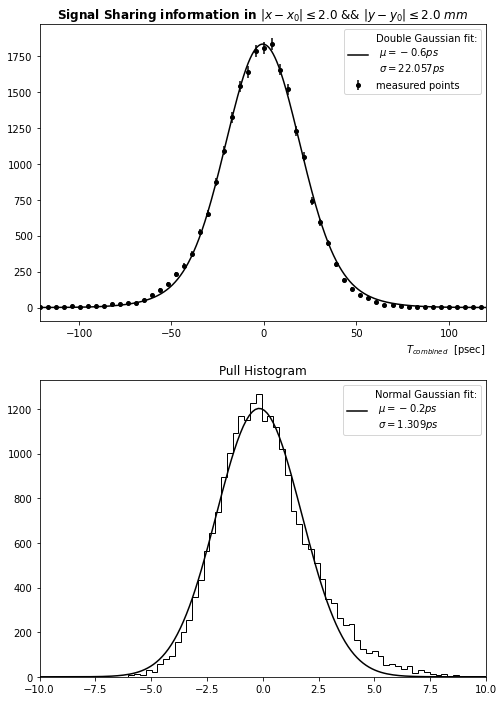

In [70]:
t_all = Tcombined[0].sat
t_all= np.concatenate((Tcombined[1].sat,Tcombined[2].sat,Tcombined[3].sat))
T = SAT(t_all)

fig,axes = plt.subplots(2,1,figsize=(8,12))


avrg,std = T.sat.mean(), T.sat.std()
    
c,_,_ = T.GetHist()
g2_par = np.array([c.max(),0.,10,c.max()/4,30])
g2_par =T.FitSAT(f = double_gaus,p0=g2_par)
(c1, mu, sigma1, c2, sigma2) = g2_par

ax = axes[0]

T.PlotSAT(ax=ax,label='measured points')
x = np.linspace(mu-5*std,mu+5*std,2000)
sigma_double = double_sigma(x,*g2_par)

r = 1.
ax.plot(x,double_gaus(x,*g2_par),color='black',
         label='Double Gaussian fit:\n $\mu = {:.1f} ps$ \n $\sigma = {:.3f} ps$'.format(mu,sigma_double-r))
ax.legend(loc='upper right')
ax.set_title(f'Signal Sharing information in $|x-x_0|\leq {radius}\ &&\ |y-y_0|\leq {radius}\ mm$', 
             fontsize=12, fontweight='bold')
ax.set_xlabel(r'$T_{combined}$  [psec]',loc='right')
ax.set_xlim(mu-5*std,mu+5*std)
ax.legend()

################
t_all = Tpull[0].sat
t_all= np.concatenate((Tpull[1].sat,Tpull[2].sat,Tpull[3].sat))
T = SAT(t_all)
ax = axes[1]
T.PlotHist(ax=ax)
c,_,b = T.GetHist()
parameters, covariance = curve_fit(simple_gaus, b, c,p0=[c.max(),0,1])
ax.plot(np.linspace(-10,10,150),simple_gaus(np.linspace(-10,10,150),*parameters),color='k',
        label='Normal Gaussian fit:\n $\mu = {:.1f} ps$ \n $\sigma = {:.3f} ps$'.format(parameters[1],
                                                                                        parameters[2]-0.6))
ax.set_title('Pull Histogram')
ax.legend()
ax.set_xlim(-10,10)

plt.show()